# Dino v2

In [7]:
import sys
import torch

In [8]:
BACKBONE_SIZE = "large" # in ("small", "base", "large" or "giant")

backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()
backbone_model.cuda()
backbone_model.to("cuda:0")

Using cache found in /home/eric/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [9]:
backbone_model

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [94]:
import numpy as np
from PIL import Image
from torchvision import transforms

dummy_image = torch.rand(1, 3, 448, 448).to("cuda:0")
dummy_image_real = Image.open("/disk3/eric/dataset/VISION_SOFS/WEAPON_4/train_mask/M5Sandstorm__part_11.png")
#dummy_image_real = np.asarray(dummy_image_real)


#--- transform
transform = transforms.Compose([
    transforms.Resize((448 , 448)) ,
    transforms.ToTensor() ,
    transforms.Normalize(mean = [0.485 , 0.456 , 0.406] , std = [0.229 , 0.224 , 0.225])
])


x = transform(dummy_image_real)
x = x.unsqueeze(0)
x.shape
x = x.to("cuda:0")
#a1 = a1.permute(2,0,1).unsqueeze(0)

filename /disk3/eric/dataset/VISION_SOFS/WEAPON_4/train_mask/M5Sandstorm__part_11.png


In [95]:
result = backbone_model.forward_features(x)

In [96]:
result

{'x_norm_clstoken': tensor([[ 2.6342, -0.9010,  0.6103,  ...,  0.2207, -1.0155,  1.4461]],
        device='cuda:0', grad_fn=<SelectBackward0>),
 'x_norm_regtokens': tensor([], device='cuda:0', size=(1, 0, 1024), grad_fn=<SliceBackward0>),
 'x_norm_patchtokens': tensor([[[-1.1472, -0.6001, -0.0691,  ...,  0.9035, -0.9072,  0.7414],
          [-0.7611,  0.2277, -0.6899,  ...,  0.7380, -0.4098, -0.0992],
          [-0.7458,  0.1011, -0.7130,  ...,  0.6854, -0.0929, -0.2081],
          ...,
          [-0.2695,  0.6628,  0.5047,  ...,  0.8674, -0.5670,  0.6213],
          [ 0.4544, -0.9525,  1.7440,  ...,  1.0358,  0.3354,  1.3464],
          [ 0.6745, -1.3254,  2.5861,  ...,  0.7155,  0.1074,  0.9740]]],
        device='cuda:0', grad_fn=<SliceBackward0>),
 'x_prenorm': tensor([[[ 3.0598, -0.7040,  0.2271,  ...,  0.7643, -0.7827,  0.9390],
          [-2.9028, -0.9561, -1.2320,  ...,  2.3521, -1.5149,  0.7477],
          [-2.1110,  0.7266, -2.5413,  ...,  2.0053, -0.5676, -0.1553],
         

In [97]:
patch_tokens = result['x_norm_patchtokens'].cpu().detach().numpy().reshape([1,1024,-1])

In [98]:
patch_tokens.shape

(1, 1024, 1024)

In [99]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt 

fg_pca = PCA(n_components=1)

masks=[]
plt.figure(figsize=(10,10))

all_patches = patch_tokens.reshape([-1,1024])
reduced_patches = fg_pca.fit_transform(all_patches)
# scale the feature to (0,1)
norm_patches = minmax_scale(reduced_patches)

# reshape the feature value to the original image size
image_norm_patches = norm_patches.reshape([1,1024])

<Figure size 1000x1000 with 0 Axes>

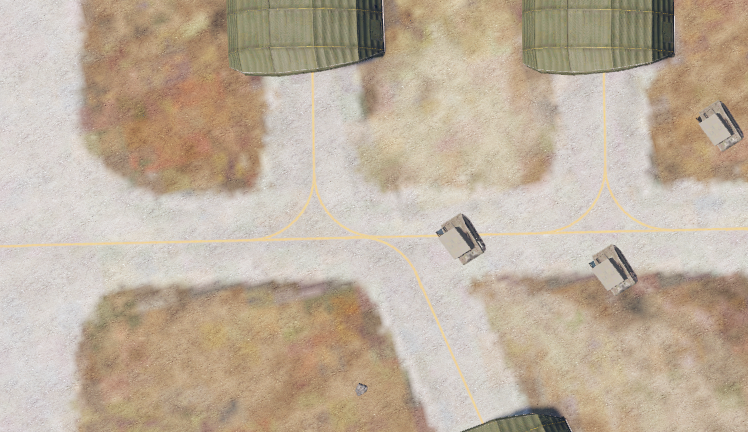

In [100]:
dummy_image_real

In [101]:
image_norm_patches.shape

(1, 1024)

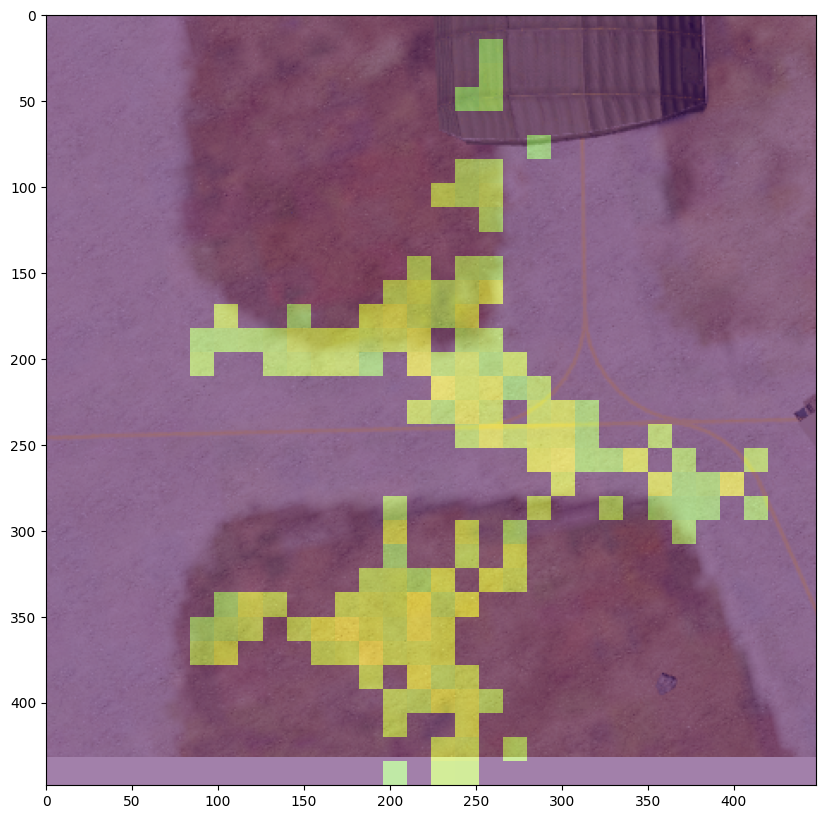

In [106]:
image_patches = image_norm_patches[0,:]

# choose a threshold to segment the foreground
mask = (image_patches > 0.8).ravel()
masks.append(mask)

image_patches[np.logical_not(mask)] = 0

plt.figure(figsize=(10, 10))
plt.imshow(dummy_image_real)
plt.imshow(image_patches.reshape([32,-1]).T, extent=(0,448,448,0), alpha=0.5)
plt.show()
